<a href="https://colab.research.google.com/github/Akash-mahandargi/Basic-Projects-/blob/main/Time_Series_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd

# Load the dataset
file_path = '/content/exchange_rate.csv'
df = pd.read_csv(file_path)

# Rename columns
df.columns = ['Date', 'Rate']

# Explicitly convert 'Date' column to datetime objects, with dayfirst=True
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Set Date as index
df.set_index('Date', inplace=True)

# Handle missing values that might exist in the original data
df['Rate'] = df['Rate'].ffill()

print("Data loaded and preprocessed successfully!")
display(df.head())

Data loaded and preprocessed successfully!


,Rate
Date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [5]:
!head -n 5 /content/exchange_rate.csv

date,Ex_rate
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.786


ADF Statistic: -1.664994
p-value: 0.449233
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Result: The series is non-stationary. We will need to use differencing (the 'd' parameter in ARIMA).


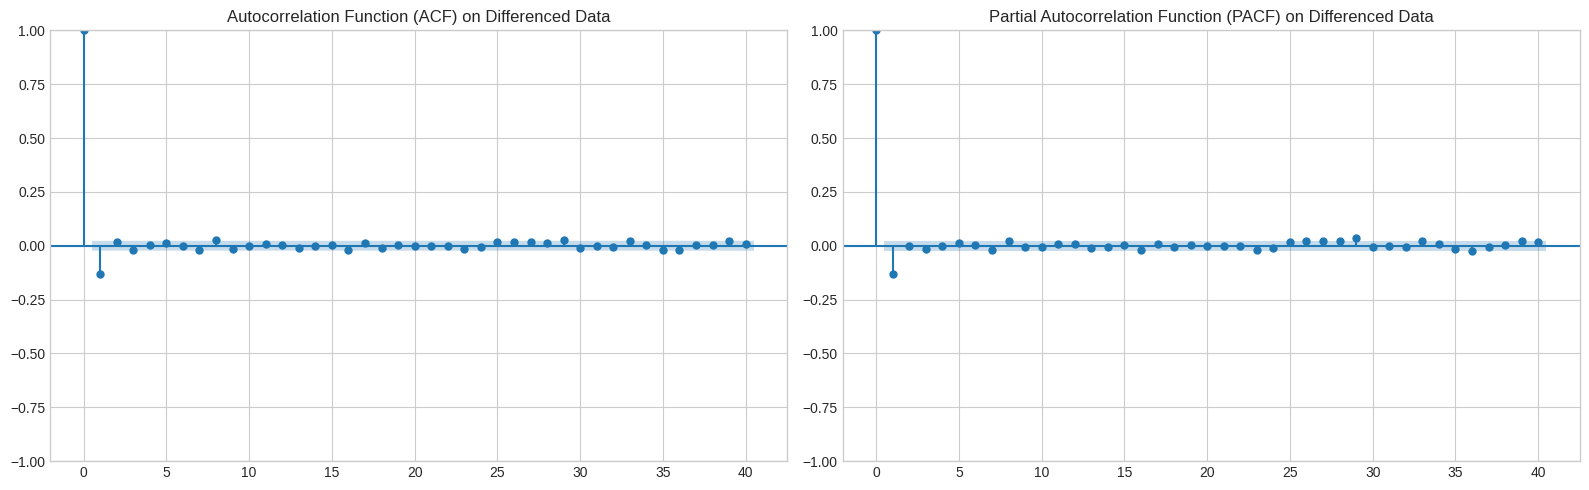

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# --- Stationarity Check (ADF Test) ---
# The null hypothesis of the ADF test is that the time series is non-stationary.
# If the p-value is less than 0.05, we reject the null hypothesis and conclude that the series is stationary.
result = adfuller(df['Rate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print("\nResult: The series is non-stationary. We will need to use differencing (the 'd' parameter in ARIMA).")
else:
    print("\nResult: The series is stationary. We can use d=0.")


# --- ACF and PACF Plots ---
# We often plot the ACF/PACF on the differenced series if the original series is non-stationary.
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot ACF
plot_acf(df['Rate'].diff().dropna(), ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF) on Differenced Data')

# Plot PACF
plot_pacf(df['Rate'].diff().dropna(), ax=axes[1], lags=40)
axes[1].set_title('Partial Autocorrelation Function (PACF) on Differenced Data')

plt.tight_layout()
plt.show()

In [34]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
# We use order=(1, 1, 1) based on our ACF/PACF analysis
# We drop NA values here to handle the NaNs introduced by asfreq
model = ARIMA(df['Rate'].dropna(), order=(1, 1, 1))

# Fit the model using a different solver
model_fit = model.fit(method='innovations_mle')

# Display the model summary
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-2998542310.py:9: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model_fit = model.fit(method='innovations_mle')


                               SARIMAX Results                                
Dep. Variable:                   Rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sat, 02 Aug 2025   AIC                         -56102.322
Time:                        19:44:02   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1261      0.045     -2.780      0.005      -0.215      -0.037
ma.L1         -0.0054      0.045     -0.119      0.905      -0.095       0.084
sigma2      3.596e-05   9.94e-08    361.609      0.0

In [16]:
from statsmodels.tsa.arima.model import ARIMA
print(ARIMA.fit.__doc__)


        Fit (estimate) the parameters of the model.

        Parameters
        ----------
        start_params : array_like, optional
            Initial guess of the solution for the loglikelihood maximization.
            If None, the default is given by Model.start_params.
        transformed : bool, optional
            Whether or not `start_params` is already transformed. Default is
            True.
        includes_fixed : bool, optional
            If parameters were previously fixed with the `fix_params` method,
            this argument describes whether or not `start_params` also includes
            the fixed parameters, in addition to the free parameters. Default
            is False.
        method : str, optional
            The method used for estimating the parameters of the model. Valid
            options include 'statespace', 'innovations_mle', 'hannan_rissanen',
            'burg', 'innovations', and 'yule_walker'. Not all options are
            available for ev

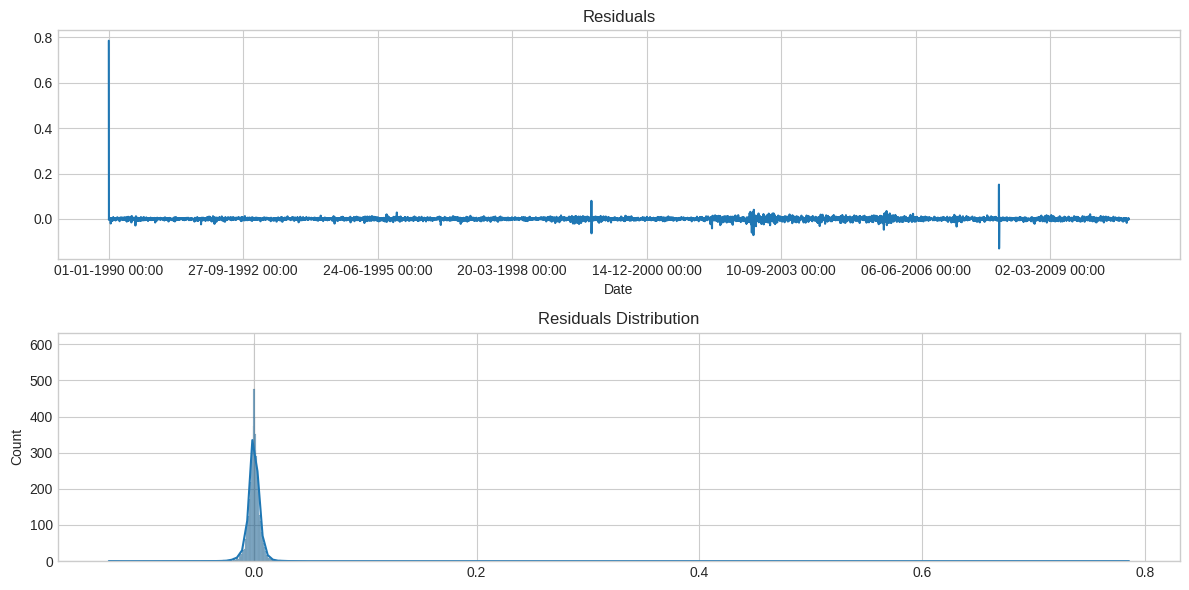

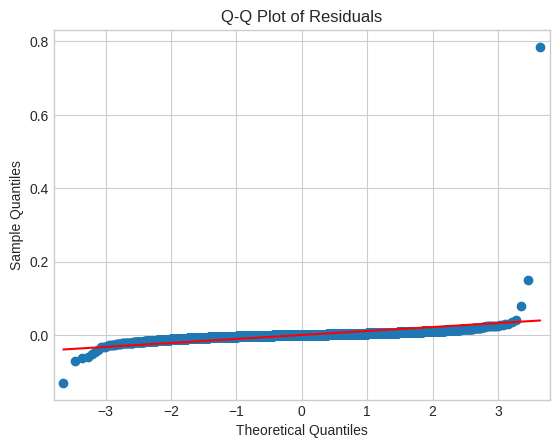


Residuals Summary Statistics:
count    7588.000000
mean        0.000094
std         0.010829
min        -0.130173
25%        -0.002388
50%         0.000129
75%         0.002603
max         0.785500
dtype: float64


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

# Get the residuals from the model
residuals = model_fit.resid

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
residuals.plot(title='Residuals', ax=plt.gca())
plt.tight_layout()

# Plot the distribution of the residuals
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, ax=plt.gca())
plt.title('Residuals Distribution')
plt.tight_layout()
plt.show()

# Create a Q-Q plot of the residuals
qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Print summary statistics of the residuals
print("\nResiduals Summary Statistics:")
print(residuals.describe())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


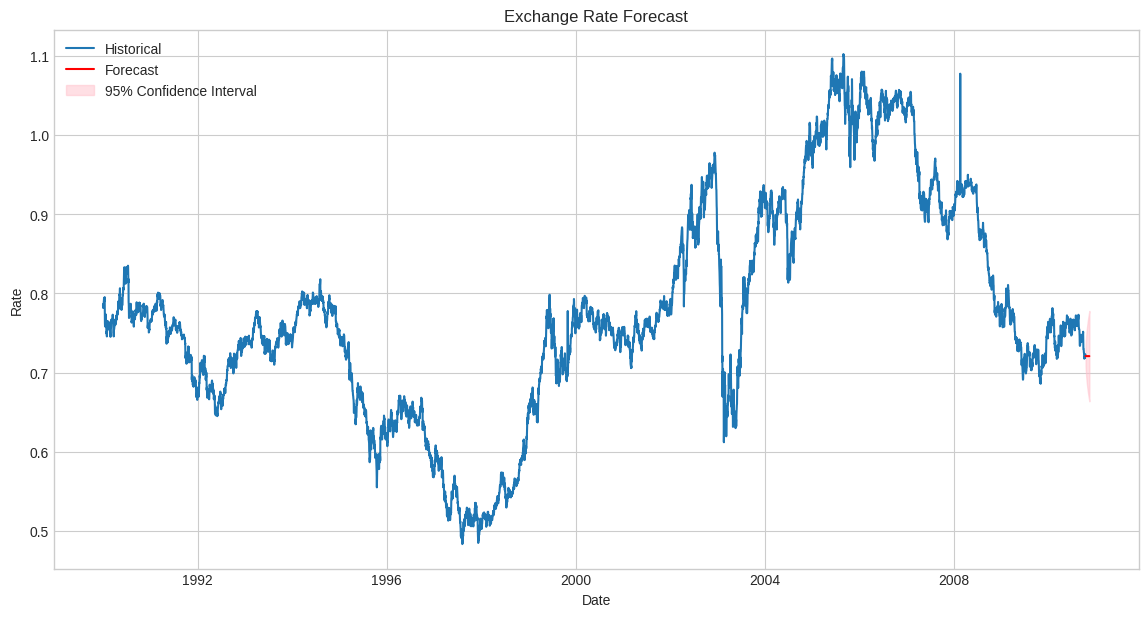


Forecast for the next 30 days:
2010-10-11    0.720827
2010-10-12    0.720826
2010-10-13    0.720826
2010-10-14    0.720826
2010-10-15    0.720826
2010-10-16    0.720826
2010-10-17    0.720826
2010-10-18    0.720826
2010-10-19    0.720826
2010-10-20    0.720826
2010-10-21    0.720826
2010-10-22    0.720826
2010-10-23    0.720826
2010-10-24    0.720826
2010-10-25    0.720826
2010-10-26    0.720826
2010-10-27    0.720826
2010-10-28    0.720826
2010-10-29    0.720826
2010-10-30    0.720826
2010-10-31    0.720826
2010-11-01    0.720826
2010-11-02    0.720826
2010-11-03    0.720826
2010-11-04    0.720826
2010-11-05    0.720826
2010-11-06    0.720826
2010-11-07    0.720826
2010-11-08    0.720826
2010-11-09    0.720826
Freq: D, dtype: float64


In [33]:
# Generate forecasts for the next 30 days
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)

# Get the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a date range for the forecast
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Rate'], label='Historical')
plt.plot(forecast_index, forecast_mean.values, color='red', label='Forecast')
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.5, label='95% Confidence Interval')

plt.title('Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

print("\nForecast for the next 30 days:")
# Create a new series with the correct index for printing
forecast_with_dates = pd.Series(forecast_mean.values, index=forecast_index)
print(forecast_with_dates)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


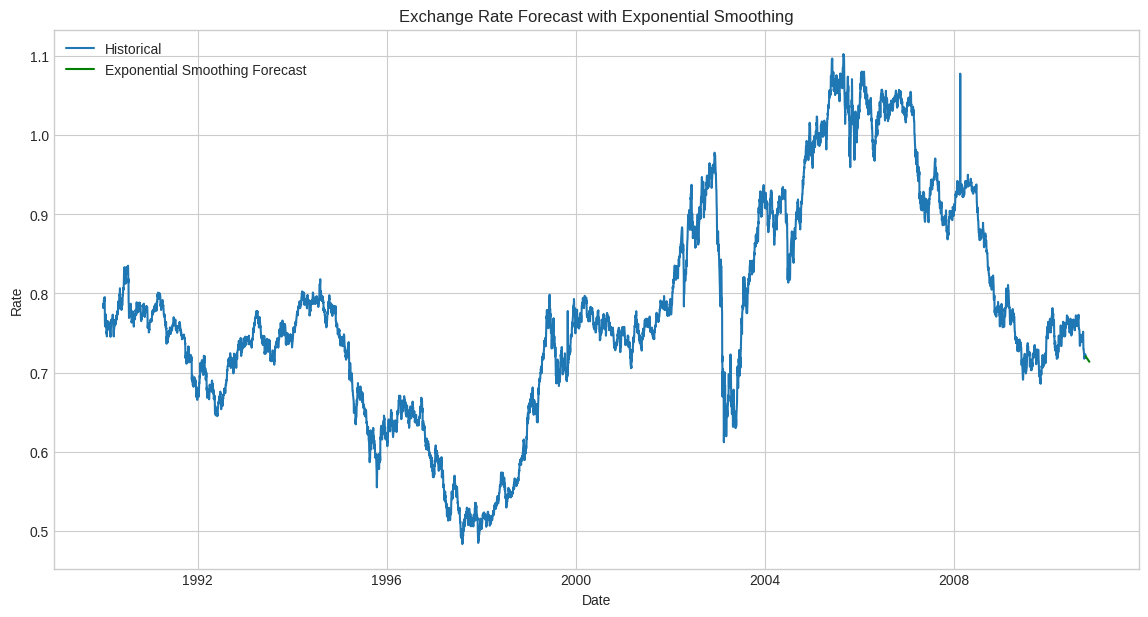


Exponential Smoothing Forecast for the next 30 days:
2010-10-11    0.720590
2010-10-12    0.720353
2010-10-13    0.720117
2010-10-14    0.719881
2010-10-15    0.719644
2010-10-16    0.719408
2010-10-17    0.719171
2010-10-18    0.718935
2010-10-19    0.718698
2010-10-20    0.718462
2010-10-21    0.718226
2010-10-22    0.717989
2010-10-23    0.717753
2010-10-24    0.717516
2010-10-25    0.717280
2010-10-26    0.717043
2010-10-27    0.716807
2010-10-28    0.716571
2010-10-29    0.716334
2010-10-30    0.716098
2010-10-31    0.715861
2010-11-01    0.715625
2010-11-02    0.715389
2010-11-03    0.715152
2010-11-04    0.714916
2010-11-05    0.714679
2010-11-06    0.714443
2010-11-07    0.714206
2010-11-08    0.713970
2010-11-09    0.713734
Freq: D, dtype: float64


In [35]:
from statsmodels.tsa.api import Holt

# --- Model Building - Exponential Smoothing (Holt's Linear Trend) ---
# Fit the model
model_es = Holt(df['Rate']).fit()

# Forecast the next 30 days
forecast_es = model_es.forecast(30)

# --- Visualization ---
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Rate'], label='Historical')
plt.plot(forecast_es.index, forecast_es.values, color='green', label='Exponential Smoothing Forecast')
plt.title('Exchange Rate Forecast with Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

print("\nExponential Smoothing Forecast for the next 30 days:")
print(forecast_es)

Training set size: 7208
Test set size: 380
Test Set Period: 2009-09-26 to 2010-10-10


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



--- Model Evaluation Metrics ---


,ARIMA,Exponential Smoothing
Metric,,
MAE,0.033213,0.076633
RMSE,0.037752,0.085796
MAPE (%),4.408711,10.200234


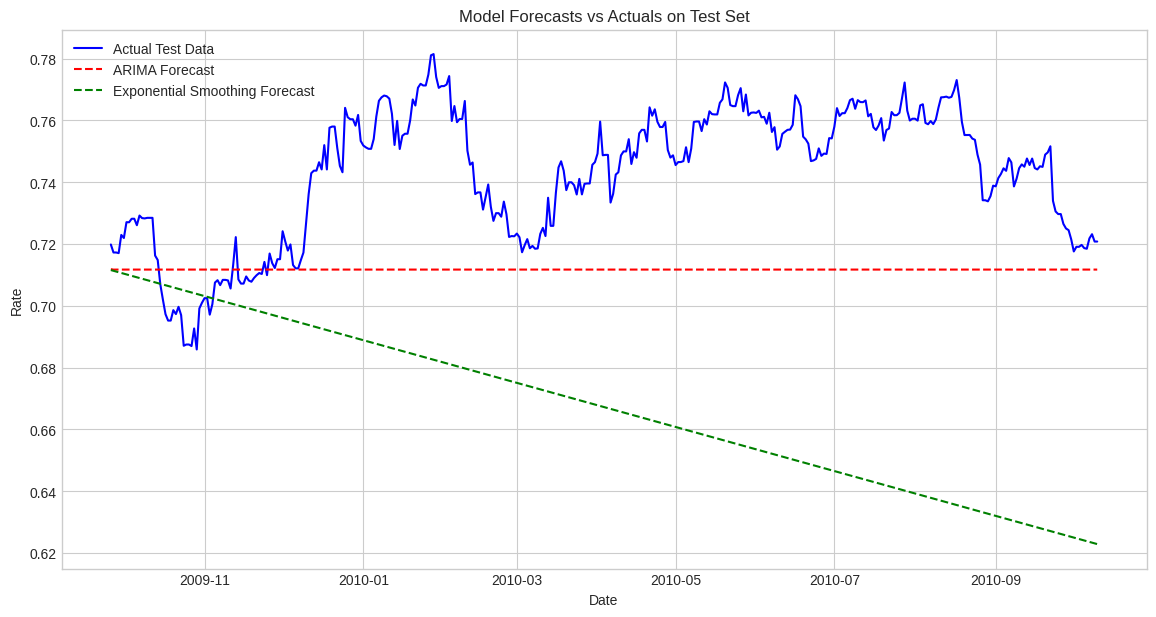

In [36]:
# --- Part 4: Evaluation and Comparison ---

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split data into training and testing sets (95% train, 5% test)
train_size = int(len(df) * 0.95)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")
print(f"Test Set Period: {test.index.min().date()} to {test.index.max().date()}")

# --- 1. Re-fit ARIMA model on the training data ---
# We use dropna() here just in case, to ensure the model fits
arima_model_eval = ARIMA(train['Rate'].dropna(), order=(1, 1, 1))
arima_fit_eval = arima_model_eval.fit() # Using default solver is fine here

# Forecast on the test set horizon
arima_forecast_eval = arima_fit_eval.get_forecast(steps=len(test))
arima_forecast_mean = arima_forecast_eval.predicted_mean
arima_forecast_mean.index = test.index # Align index for comparison

# --- 2. Re-fit Exponential Smoothing model on the training data ---
es_model_eval = Holt(train['Rate'].dropna()).fit()

# Forecast on the test set horizon
es_forecast_eval = es_model_eval.forecast(steps=len(test))
es_forecast_eval.index = test.index # Align index for comparison

# --- 3. Calculate Error Metrics ---
# ARIMA Metrics
mae_arima = mean_absolute_error(test['Rate'], arima_forecast_mean)
rmse_arima = np.sqrt(mean_squared_error(test['Rate'], arima_forecast_mean))
mape_arima = np.mean(np.abs((test['Rate'] - arima_forecast_mean) / test['Rate'])) * 100

# Exponential Smoothing Metrics
mae_es = mean_absolute_error(test['Rate'], es_forecast_eval)
rmse_es = np.sqrt(mean_squared_error(test['Rate'], es_forecast_eval))
mape_es = np.mean(np.abs((test['Rate'] - es_forecast_eval) / test['Rate'])) * 100

# --- 4. Print and Compare Metrics ---
results_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)'],
    'ARIMA': [mae_arima, rmse_arima, mape_arima],
    'Exponential Smoothing': [mae_es, rmse_es, mape_es]
}).set_index('Metric')

print("\n--- Model Evaluation Metrics ---")
display(results_df)


# --- 5. Visualization of Forecast vs Actuals on Test Set ---
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Rate'], label='Actual Test Data', color='blue')
plt.plot(test.index, arima_forecast_mean, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(test.index, es_forecast_eval, label='Exponential Smoothing Forecast', color='green', linestyle='--')
plt.title('Model Forecasts vs Actuals on Test Set')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()